In [43]:
from gensim.models import Word2Vec
from sklearn import linear_model
import gensim
import operator
import string
import random
import numpy as np
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder
from nltk.stem import WordNetLemmatizer 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances,euclidean_distances,jaccard_similarity_score

In [44]:
# Read the dataframe
df = pd.read_csv('dialog_preprocessed.csv')
df

,context,response
0,tell me about your personality,Just think of me as the ace up your sleeve.
1,i want to know you good,I can help you work smarter instead of harder
2,define yourself,Just think of me as the ace up your sleeve.
3,describe yourself,Just think of me as the ace up your sleeve.
4,tell me about yourself,Just think of me as the ace up your sleeve.
...,...,...
1501,can we chat,I'm always here to lend an ear.
1502,ill be back in a few minute,I'll be waiting.
1503,ill be back,All right. I'll be here.
1504,ill get back to you in a moment,Till next time.


In [45]:
# Class for text normalization
class Normalize():
    def __init__(self, sentences):
        '''
        Takes a Dataframe as the input. ALl columns should contain text or atleast the ones you wish to preprocess
        '''
        if isinstance(sentences, pd.DataFrame):
            self.dataframe = sentences.copy()
        else:
            self.dataframe = pd.DataFrame([])
        
    
    def replace_characters(self, string, characters = '''[<>\[\/]-_'.?()]'''):
        '''
        Replace characters in a string given by `characters` parameter and returns the text with replaced string
        '''
        for char in characters:
            string = string.replace(char, '')    
        return string
    
    def lemmatize_string(self,sentence):
        '''
        Replace all words in a sentence by its lemma using Part-of-Speech Tags
        '''
        lemmas = []
        lemmatizer = WordNetLemmatizer()
        
        for word,tag in nltk.pos_tag(sentence.split()):
            if tag.startswith('N'): #Noun
                pos_character = 'n'
            elif tag.startswith('V'): #Verb
                pos_character = 'v'
            elif tag.startswith('J'): #Adjective
                pos_character = 'a'
            elif tag.startswith('R'): #Adverb
                pos_character = 'r'
            else:
                 pos_character = 'v'    
            lemma = lemmatizer.lemmatize(word, pos=pos_character)
            if pos_character == 'r' and lemma==word:
                lemma = lemmatizer.lemmatize(word, pos='a')
            lemmas.append(lemma)
        return ' '.join(lemmas)
    
    def lowercase(self, string):
        '''
        Convert each string to lowercase
        '''
        return string.lower()
    
    def remove_stopwords_string(self, sentence):
        '''
        Removes all stop words of the sentence using NLTK default English stopwords
        '''
        words = []
        stop_words = list(set(stopwords.words('english')))
        for word in nltk.word_tokenize(sentence):
            if word not in stop_words:
                words.append(word)
        return ' '.join(words)
    
    def lemmatize(self, columns, inplace=False):
        '''
        Lemmatize the columns of the dataframe and returns it
        `columns`: List of columns
        `inplace`: If True, do operation inplace and return None.
        '''
        dataframe = self.dataframe.copy()
        for column in columns:
            dataframe[column] = dataframe[column].apply(self.lemmatize_string)
        if inplace:
            self.dataframe = dataframe.copy()
        return dataframe
    

        
    def remove_stopwords(self, columns, inplace=False):
        '''
        Removes the stopwords of the dataframe and returns it
        `columns`: List of columns
        `inplace`: If True, do operation inplace and return None.
        '''
        dataframe = self.dataframe.copy()
        for column in columns:
            dataframe[column] = dataframe[column].apply(self.remove_stopwords_string)
        if inplace:
            self.dataframe = dataframe.copy()
        return dataframe
    
    def remove_special_characters(self, columns, inplace=False):
        '''
        Removes the special characters of the dataframe and returns it
        `columns`: List of columns
        `inplace`: If True, do operation inplace and return None.
        '''
        dataframe = self.dataframe.copy()
        for column in columns:
            dataframe[column] = dataframe[column].apply(self.replace_characters)
        if inplace:
            self.dataframe = dataframe.copy()
        return dataframe
    
    def convert_to_lowercase(self, columns, inplace=False):
        '''
        Converts the sentences of the dataframe and returns it
        `columns`: List of columns
        `inplace`: If True, do operation inplace and return None.
        '''
        dataframe = self.dataframe.copy()
        for column in columns:
            dataframe[column] = dataframe[column].apply(self.lowercase)
        if inplace:
            self.dataframe = dataframe.copy()
        return dataframe
    
    def preprocess_string(self, string):
        '''
        Does the following steps
        1. Convert to lowercase
        2. Replace all special characters (default characters)
        3. Lemmatize all words by their POS tags
        '''
        lower = self.lowercase(string)
        replaced = self.replace_characters(lower)
        lemmatized = self.lemmatize_string(replaced)
        return lemmatized
    
    def preprocess(self, columns, inplace=False):
        '''
        Preprocesses the sentences of the dataframe and returns it
        `columns`: List of columns
        `inplace`: If True, do operation inplace and return None.
        '''
        dataframe = self.dataframe.copy()
        for column in columns:
            dataframe[column] = dataframe[column].apply(self.preprocess_string)
        if inplace:
            self.dataframe = dataframe.copy()
        return dataframe

In [46]:
# Sample question
question = 'Can you please talk to me?'

# Normalizing the question with preprocessing steps
normalize = Normalize(question)
preprocessed_question = normalize.preprocess_string(question) 
preprocessed_question

'can you please talk to me'

# Count Vectorizer/Bag of Words

Count vectorizer will give equal weightage to stopwords. So we will remove them before vectorizing

In [47]:
# Remove Stopwords
normalize_dataframe = Normalize(df)
df_without_stopwords = normalize_dataframe.remove_stopwords(columns = ['context'], inplace=True)
df_without_stopwords.head()

,context,response
0,tell personality,Just think of me as the ace up your sleeve.
1,want know good,I can help you work smarter instead of harder
2,define,Just think of me as the ace up your sleeve.
3,describe,Just think of me as the ace up your sleeve.
4,tell,Just think of me as the ace up your sleeve.


All stopwords are removed from `context` column

In [48]:
# Vectorizing our context
count_vectorizer = CountVectorizer()
X = df_without_stopwords['context']
vectors = count_vectorizer.fit_transform(X).toarray()
feature_names = count_vectorizer.get_feature_names()
df_vectorized = pd.DataFrame(vectors, columns=feature_names)
df_vectorized.head()

,21,abort,absolutely,abysmal,actually,adore,advice,advise,affirmative,afraid,...,ye,yea,yeah,year,yeh,yep,yes,yet,youre,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Very sparse matrix with 442 columns in total

In [49]:
# Have to remove stopwords from question as well
question_without_stopwords = normalize.remove_stopwords_string(preprocessed_question)
question_without_stopwords

'please talk'

The words *can*, *you*, *to* and *me* have been removed, but still the meaning of the question has not been changed dramatically

In [50]:
# Converting our question to BOW model with transform
question_vector = count_vectorizer.transform([question_without_stopwords]).toarray()
question_vector

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Sparse matrix with only 2 non-zero values

### Similarity
Now we will compare our question vector to all the possible sentence vectors using a metric called cosine similarity. The values will range from 0 to 1. We will use it in such a way that values closer to 1 are more similar.

In [51]:
cosine_similarities = 1 - pairwise_distances(question_vector,vectors, metric='cosine')[0]
cosine_similarities

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
responses = df_without_stopwords['response'].values
responses

array(['Just think of me as the ace up your sleeve.',
       'I can help you work smarter instead of harder',
       'Just think of me as the ace up your sleeve.', ...,
       "All right. I'll be here.", 'Till next time.',
       'Okay. You know where to find me.'], dtype=object)

In [53]:
# Zipping the two arrays into a list of tuples to convert it to a dataframe
dataframe_values = list(zip(cosine_similarities, responses))
dataframe_values[:10]

[(0.0, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'I can help you work smarter instead of harder'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'I can help you work smarter instead of harder'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.4999999999999999, 'I can help you work smarter instead of harder'),
 (0.7071067811865475, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'I can help you work smarter instead of harder')]

In [54]:
# Our dataframe consisting of similarity score and response
similarity_df = pd.DataFrame(dataframe_values, columns=['similarity', 'response'])
similarity_df

,similarity,response
0,0.0,Just think of me as the ace up your sleeve.
1,0.0,I can help you work smarter instead of harder
2,0.0,Just think of me as the ace up your sleeve.
3,0.0,Just think of me as the ace up your sleeve.
4,0.0,Just think of me as the ace up your sleeve.
...,...,...
1501,0.0,I'm always here to lend an ear.
1502,0.0,I'll be waiting.
1503,0.0,All right. I'll be here.
1504,0.0,Till next time.


In [55]:
# Taking all responses which are atleast 20% similar to the question
threshold = 0.2
thresholded_df = similarity_df[similarity_df['similarity'] > threshold]
thresholded_df

,similarity,response
7,0.500000,I can help you work smarter instead of harder
8,0.707107,Just think of me as the ace up your sleeve.
180,0.500000,I'm glad to help. What can I do for you?
295,0.316228,Thanks.
377,0.500000,"In the virtual sense that I can, sure."
506,0.707107,My pleasure.
507,0.707107,My pleasure.
509,0.707107,My pleasure.
511,0.707107,My pleasure.
514,0.707107,My pleasure.


Some responses have been filtered out. This is called collaborative filtering

In [56]:
# Sorting the responses by similarity
thresholded_df_sorted = thresholded_df.sort_values(by='similarity', ascending=False)
thresholded_df_sorted

,similarity,response
521,0.707107,Sure! Let's talk.
1498,0.707107,Good conversation really makes my day.
8,0.707107,Just think of me as the ace up your sleeve.
506,0.707107,My pleasure.
507,0.707107,My pleasure.
509,0.707107,My pleasure.
511,0.707107,My pleasure.
514,0.707107,My pleasure.
516,0.707107,My pleasure.
517,0.707107,My pleasure.


In [57]:
max_similarity_value = thresholded_df_sorted['similarity'].max()
thresholded_df_sorted_max = thresholded_df_sorted[thresholded_df_sorted['similarity'] == max_similarity_value]
thresholded_df_sorted_max.head()

,similarity,response
521,0.707107,Sure! Let's talk.
1498,0.707107,Good conversation really makes my day.
8,0.707107,Just think of me as the ace up your sleeve.
506,0.707107,My pleasure.
507,0.707107,My pleasure.


Since a chatbot can have only one response, we will take the response with the maximum similarity but some of the top responses have equal similarity as shown above. So these are the possible responses to the question. We will just take the first response for now

In [58]:
response = thresholded_df_sorted_max.iloc[0]['response']
response

"Sure! Let's talk."

The output matches our expected response to the question "Can you please talk to me?"

In [59]:
# Save the model for future use
np.save('models/bow', vectors)

# TF-IDF Vectorizer

One limitation of the Bag of Words model was that all words were given equal weightage. In TF-IDF, words which are frequently occuring within all documents are given less weightage, so stopwords need not be removed 

In [60]:
# Converting to TF-IDF vectors
tf_idf = TfidfVectorizer()
X = df['context']
vectors = tf_idf.fit_transform(X)
feature_names = tf_idf.get_feature_names()
denselist = vectors.toarray()
df_vectorized_tf_idf = pd.DataFrame(denselist, columns=feature_names)
df_vectorized_tf_idf.head()

,21,abort,about,absolutely,abysmal,actually,adore,advice,advise,affirmative,...,yeh,yep,yes,yet,you,your,youre,yours,yourself,yup
0,0.0,0.0,0.414383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.331963,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.218488,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.641254,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.641254,0.0
4,0.0,0.0,0.461621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.606213,0.0


In [61]:
from itertools import islice
from wordcloud import WordCloud
# Get frequencies of each word
freqs = {word: vectors.getcol(idx).sum() for word, idx in tf_idf.vocabulary_.items()}
# Printing some frequencies
list(islice(freqs.items(),10))

[('tell', 6.408770166405369),
 ('me', 38.808919241506615),
 ('about', 15.661957412651768),
 ('your', 33.35568575077785),
 ('personality', 1.3584258300603216),
 ('want', 18.90847961364475),
 ('to', 49.42662255553179),
 ('know', 7.4095751385557165),
 ('you', 131.71220756779618),
 ('good', 53.3993300972422)]

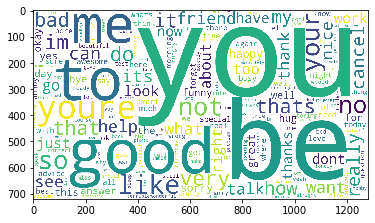

In [62]:
w = WordCloud(width=1280,height=720,mode='RGBA',background_color='white').fit_words(freqs)
plt.imshow(w)
plt.show()

This is the wordcloud for the data. Bigger the text, the more frequently it occurs

In [63]:
# Converting our question to TF-IDF format with transform
question_vector = tf_idf.transform([preprocessed_question]).toarray()
question_vector

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

### Similarity

In [64]:
cosine_similarities = 1 - pairwise_distances(question_vector,vectors, metric='cosine')[0]
cosine_similarities

array([0.11086213, 0.15801205, 0.        , ..., 0.        , 0.09579113,
       0.08654955])

In [65]:
# Same procedure as in Bag of Words
responses = df['response']
dataframe_values = list(zip(cosine_similarities, responses))
dataframe_values[:10]

[(0.11086213022991342, 'Just think of me as the ace up your sleeve.'),
 (0.15801205154259634, 'I can help you work smarter instead of harder'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'Just think of me as the ace up your sleeve.'),
 (0.12349998435382292, 'Just think of me as the ace up your sleeve.'),
 (0.04734590671572003, 'I can help you work smarter instead of harder'),
 (0.12875840288342033, 'Just think of me as the ace up your sleeve.'),
 (0.20717413226853454, 'I can help you work smarter instead of harder'),
 (0.22665370771328464, 'Just think of me as the ace up your sleeve.'),
 (0.0, 'I can help you work smarter instead of harder')]

In [66]:
# Get similarity score
similarity_df = pd.DataFrame(dataframe_values, columns=['similarity', 'response'])
similarity_df

,similarity,response
0,0.110862,Just think of me as the ace up your sleeve.
1,0.158012,I can help you work smarter instead of harder
2,0.000000,Just think of me as the ace up your sleeve.
3,0.000000,Just think of me as the ace up your sleeve.
4,0.123500,Just think of me as the ace up your sleeve.
...,...,...
1501,0.193416,I'm always here to lend an ear.
1502,0.000000,I'll be waiting.
1503,0.000000,All right. I'll be here.
1504,0.095791,Till next time.


In [67]:
# Filtering by threshold
thresholded_df = similarity_df[similarity_df['similarity'] > 0.2]
thresholded_df

,similarity,response
7,0.207174,I can help you work smarter instead of harder
8,0.226654,Just think of me as the ace up your sleeve.
31,0.228073,Sorry to make you feel so.
34,0.217457,Sorry to make you feel so.
41,0.212315,Can you try asking it a different way?
...,...,...
1495,0.353200,I'm always here to lend an ear.
1497,0.234421,Talking is what I do best.
1498,0.455022,Good conversation really makes my day.
1499,0.282537,Talking is what I do best.


In [68]:
# Sorting the responses by similarity
thresholded_df_sorted = thresholded_df.sort_values(by='similarity', ascending=False)
thresholded_df_sorted

,similarity,response
514,0.786101,My pleasure.
517,0.786101,My pleasure.
509,0.642941,My pleasure.
516,0.637124,My pleasure.
180,0.602085,I'm glad to help. What can I do for you?
...,...,...
41,0.212315,Can you try asking it a different way?
1267,0.209260,No problem. You know where to find me when you...
380,0.207317,Of course we are.
7,0.207174,I can help you work smarter instead of harder


Similar to Bag-Of-Words, we will take the response with the maximum similarity but some of the top responses have equal similarity as shown above. So these are the possible responses to the question. We will just take the first response for now

In [69]:
response = thresholded_df_sorted.iloc[0]['response']
response

'My pleasure.'

This also gives a satisfying output to the question

In [70]:
np.save('models/tf_idf', vectors)

# Word2Vec

The problem with Bag of Words and TF-IDF model is the generation of sparse matrices and high dimensionality when trained with a lot of words. Due to scalability issues, I am using the Word2Vec model. In this case I am using Stanford's GloVe model of 6 Billion words with 50 dimensions.

In [71]:

def vectorize_sentence(word2vec_dict, sentence):
    '''
    Function to calculate the average vector of a sentence.
    '''
    words = sentence.split()
    count = 0
    # Initialize vector with all zeroes
    vector = np.zeros(50)
    for word in words:
        # Add the word vector of each word to our final vector
        try:
            vector = vector + word2vec_dict[word]
            count+=1
        except KeyError: # If unknown word occurs, decrement the count
            count-=1
    if count==0: # Sometimes, count will be zero when every word in sentence is unknown, so then return vector
        return vector
    return vector/float(count) # Return mean of our vector

In [72]:
# Load GloVe model (Will take some time)
word_vector_path = "glove.6B.50d.txt"
vector_dim = 50
word_vector = gensim.models.KeyedVectors.load_word2vec_format(word_vector_path, binary=False)

In [73]:
# Vectorize our question with GloVe
question_vector = vectorize_sentence(word_vector, preprocessed_question)
question_vector

array([ 0.14512735,  0.35477117,  0.34285367, -0.33025083,  0.41318666,
       -0.32179733, -0.27121316,  0.2224912 , -0.34780533,  0.12764117,
       -0.27399832,  0.78636999, -0.10557667, -0.0335205 ,  0.86022834,
        0.64757333,  0.15420216, -0.12893   ,  0.24836666, -0.90014332,
       -0.02540667,  0.43151583,  0.63982167,  0.5475    ,  0.80457233,
       -1.84290004, -0.65503651,  0.00733833,  0.85945834, -0.98848833,
        3.23245001,  0.69405835, -0.74005832, -0.2031275 , -0.26668166,
       -0.17088434,  0.28765333, -0.24798167,  0.23277834, -0.45179   ,
        0.29280534,  0.15739233, -0.03531416,  0.45600001,  0.26649167,
        0.15978583,  0.13239083, -0.10304384, -0.074978  ,  0.74271001])

In [74]:
sentences = df['context']
sentences.head()

0    tell me about your personality
1           i want to know you good
2                   define yourself
3                 describe yourself
4            tell me about yourself
Name: context, dtype: object

In [75]:
# Create our Word2Vec Model by vectorizing each context
glove_vectors = np.array(list(map(lambda x: vectorize_sentence(word_vector,x), sentences.values)))
glove_vectors.shape

(1506, 50)

### Similarity

This is the same procedure as the last two models

In [76]:
cosine_similarities = 1 - pairwise_distances([question_vector],glove_vectors, metric='cosine')[0]
cosine_similarities

array([0.95206484, 0.97077604, 0.82653246, ..., 0.81852277, 0.8957571 ,
       0.92109151])

In [77]:
responses = df['response']
dataframe_values = list(zip(cosine_similarities, responses))
similarity_df = pd.DataFrame(dataframe_values, columns=['similarity', 'response'])
similarity_df

,similarity,response
0,0.952065,Just think of me as the ace up your sleeve.
1,0.970776,I can help you work smarter instead of harder
2,0.826532,Just think of me as the ace up your sleeve.
3,0.895592,Just think of me as the ace up your sleeve.
4,0.961957,Just think of me as the ace up your sleeve.
...,...,...
1501,0.936108,I'm always here to lend an ear.
1502,0.788499,I'll be waiting.
1503,0.818523,All right. I'll be here.
1504,0.895757,Till next time.


In [78]:
thresholded_df = similarity_df[similarity_df['similarity'] > 0.2]
thresholded_df

,similarity,response
0,0.952065,Just think of me as the ace up your sleeve.
1,0.970776,I can help you work smarter instead of harder
2,0.826532,Just think of me as the ace up your sleeve.
3,0.895592,Just think of me as the ace up your sleeve.
4,0.961957,Just think of me as the ace up your sleeve.
...,...,...
1501,0.936108,I'm always here to lend an ear.
1502,0.788499,I'll be waiting.
1503,0.818523,All right. I'll be here.
1504,0.895757,Till next time.


Only 47 rows have been removed. So we should increase our threshold

In [79]:
thresholded_df = similarity_df[similarity_df['similarity'] > 0.9]
thresholded_df

,similarity,response
0,0.952065,Just think of me as the ace up your sleeve.
1,0.970776,I can help you work smarter instead of harder
4,0.961957,Just think of me as the ace up your sleeve.
5,0.936232,I can help you work smarter instead of harder
6,0.957727,Just think of me as the ace up your sleeve.
...,...,...
1498,0.966388,Good conversation really makes my day.
1499,0.961506,Talking is what I do best.
1500,0.975769,I'm here to chat anytime you like.
1501,0.936108,I'm always here to lend an ear.


Even after putting a threshold of 90% similarity, only half were filtered. Will sort and take the maximum value

In [80]:
thresholded_df_sorted = thresholded_df.sort_values(by='similarity', ascending=False)
thresholded_df_sorted

,similarity,response
517,0.991714,My pleasure.
514,0.991714,My pleasure.
50,0.986303,I'm not programmed for that exact question. Tr...
1442,0.982868,Probably I won't be able to give you the right...
506,0.981603,My pleasure.
...,...,...
841,0.900464,I see.
1267,0.900362,No problem. You know where to find me when you...
1072,0.900349,Bye-bye!
247,0.900300,You're pretty smart yourself.


In [81]:
response = thresholded_df_sorted.iloc[0]['response']
response

'My pleasure.'

In [83]:
np.save('models/word2vec', glove_vectors)

# Conclusion

- Chatbot works well with all models
- Bag-of-Words model might be the best for this dataset but the problem of stopwords is a big issue. Some stopwords might change the meaning of the sentence
- TF-IDF was giving good result with stopwords, but the problem is high dimensionality when no of words in our vocabulary increases. Then we would need to do some kind of dimensionality reduction technique like LSA or PCA
- Word2Vec is better suited for chatbots because chatbots depend on fast response times and the low dimensionality of the vectors help. The only drawback is that it might cause some ambiguity in response
- All these models have the same problem that they are not considering the order of words occuring <br>
Eg "Who killed Ravan" and "Ravan killed whom"  might give different results in a generalized chatbot

# Future Work

- Gather more data
- Build a sequence to sequence model using RNN/LSTM
- Spell correction
- Open Domain Chatbot
- Multi Lingual Chatbot